In [1]:
from fastai.vision import *
from fastai import *
from fastai.callbacks import *

In [2]:
path = untar_data(URLs.PASCAL_2007)
path.ls()

[PosixPath('/home/jupyter/.fastai/data/pascal_2007/train.json'),
 PosixPath('/home/jupyter/.fastai/data/pascal_2007/valid.json'),
 PosixPath('/home/jupyter/.fastai/data/pascal_2007/test.json'),
 PosixPath('/home/jupyter/.fastai/data/pascal_2007/test'),
 PosixPath('/home/jupyter/.fastai/data/pascal_2007/train')]

In [3]:
trn_images, trn_bbox = get_annotations(path/'train.json')
val_images, val_bbox = get_annotations(path/'valid.json')
images_ttl,bbox_ttl = trn_images + val_images, trn_bbox + val_bbox
img2bbox = dict(zip(images_ttl,bbox_ttl))
get_y_func = lambda o: img2bbox[o.name]

In [4]:
data = (ObjectItemList
        .from_folder(path/'train')
        .split_by_rand_pct()
        .label_from_func(get_y_func)
        .transform(get_transforms(max_rotate=3.,max_zoom=1.,p_affine=0.5,p_lighting=0.5),size=224,tfm_y=True,resize_method=ResizeMethod.SQUISH)
        .databunch(bs=64,collate_fn=bb_pad_collate,num_workers=8)
        .normalize(imagenet_stats)
       )

In [5]:
#Helper function
def un_pad(boxes,labels):
    bb_keep = ((boxes[:,2] - boxes[:,0])>0).nonzero()[:,0]
    return boxes[bb_keep],labels[bb_keep]

def box_area(boxes):
    return (boxes[:,2] - boxes[:,0]) * (boxes[:,3] - boxes[:,1])

def intersect(box_a,box_b):
    #make sure box_a and box_b exists, otherwise undefine behavior if you call the func
    top_left = torch.max(box_a[:,None,:2],box_b[None,:,:2])
    bot_right = torch.min(box_a[:,None,2:],box_b[None,:,2:])
    inter = torch.clamp((bot_right - top_left),min=0)
    return inter[:,:,0] * inter[:,:,1]

def iou(bbox,anchor):
    #bbox is gt_bb, anchor is anchor box, all in fastai style
    if len(bbox.shape) == 1: bbox = bbox[None,...]
    inter = intersect(bbox,anchor)
    union = box_area(bbox).unsqueeze(dim=1) + box_area(anchor).unsqueeze(dim=0) - inter #to broadcast shape to (N,16),where N is number of gt_bb for single image
    return inter / union


# def create_grid(size):
#     "Create a grid of a given `size`."
#     H, W = size if is_tuple(size) else (size,size)
#     grid = FloatTensor(H, W, 2)
#     linear_points = torch.linspace(-1+1/W, 1-1/W, W) if W > 1 else tensor([0.])
#     grid[:, :, 1] = torch.ger(torch.ones(H), linear_points).expand_as(grid[:, :, 0])
#     linear_points = torch.linspace(-1+1/H, 1-1/H, H) if H > 1 else tensor([0.])
#     grid[:, :, 0] = torch.ger(linear_points, torch.ones(W)).expand_as(grid[:, :, 1])
#     return grid.view(-1,2)

def show_anchors(ancs, size):
    _,ax = plt.subplots(1,1, figsize=(5,5))
    ax.set_xticks(np.linspace(-1,1, size[1]+1))
    ax.set_yticks(np.linspace(-1,1, size[0]+1))
    ax.grid(True, which='both')
    ax.scatter(ancs[:,1], ancs[:,0]) #y is first
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlim(-1,1)
    ax.set_ylim(1,-1) #-1 is top, 1 is bottom
    for i, (x, y) in enumerate(zip(ancs[:, 1], ancs[:, 0])): ax.annotate(i, xy = (x,y))
        
# def create_anchor_box(size):
#     H,W = size if is_tuple(size) else (size,size)
#     anchors_center = create_grid((H,W))
#     anchors_size = tensor([[2 / H, 2 / W] for i in range(H * W)])
#     return torch.cat([anchors_center,anchors_size],dim=1)

#convert box to fastai style top left bot right anchor box
def cthw2corners(boxes):
    top = (boxes[:,0] - boxes[:,2]/2).view(-1,1)
    left = (boxes[:,1] - boxes[:,3]/2).view(-1,1)
    bot = (boxes[:,0] + boxes[:,2]/2).view(-1,1)
    right = (boxes[:,1] + boxes[:,3]/2).view(-1,1)
    return torch.cat([top,left,bot,right],dim=1)

#anchor (center,h,w)
#fastai y (top left bot right)
#convert activation to fastai y style
#assume activation is (center,h,w)
def act_to_bbox(activation,anchor):
    activation = torch.tanh(activation) #force scale to be -1,1
    act_center = anchor[:,:2] + (activation[:,:2]/2 * grid_sizes.float().to(activation.device))
    act_hw = anchor[:,2:] * (activation[:,2:]/2 + 1)
    return cthw2corners(torch.cat([act_center,act_hw],dim=1))

def map_to_gt(overlaps):
    prior_overlap,prior_idx = overlaps.max(dim=1)
    sec_overlap,sec_idx = overlaps.max(dim=0)
    sec_overlap[prior_idx] = 4.99
    for i,o in enumerate(prior_idx): 
        sec_idx[o] = i
    return sec_overlap,sec_idx

In [6]:
class StdConv(nn.Module):
    def __init__(self,ni,nf,stride=2,drop=0.1):
        super().__init__()
        self.conv = conv_layer(ni,nf,stride=stride)
        self.drop = nn.Dropout(drop)
        
    def forward(self,x):
        return self.drop(self.conv(x))
        
class OutConv(nn.Module):
    def __init__(self,ni,k):
        super().__init__()
        self.k = k
        self.oconv_label = conv2d(ni,21*self.k,bias=True) #21 is number of classes + bg
        self.oconv_box = conv2d(ni,4*self.k,bias=True)
    
    def forward(self,x):
        label = self.oconv_label(x) #shape 64,21*k,h,w 
        box = self.oconv_box(x) #shape 64,4*k,h,w
        return [flatten(box,self.k),flatten(label,self.k)]
    
def flatten(x,k):
    #return size of bs,r*c,nf
    #flatten the output to match desgined y structure, (16,4),(16,21) single item style
    bs,nf,row,col = x.shape
    x = x.view(bs,nf//k,-1)
    return x.permute(0,2,1)

In [7]:
class SSD_multi_Model(nn.Module):
    def __init__(self,arch=models.resnet34,k=9):
        super().__init__()
        self.k = k
        self.body = create_body(arch)
        self.drop = nn.Dropout(0.25)
        self.sconv0 = StdConv(num_features_model(self.body),256,stride=1,drop=0.4) #7 by 7
        self.sconv1 = StdConv(256,256,drop=0.4) # 4 by 4
        self.sconv2 = StdConv(256,256,drop=0.4) # 2 by 2
        self.sconv3 = StdConv(256,256,drop=0.4) # 1 by 1
        self.out1 = OutConv(256,self.k)
        self.out2 = OutConv(256,self.k)
        self.out3 = OutConv(256,self.k)

    def forward(self,xb):
        xb = self.drop(F.relu(self.body(xb)))
        xb = self.sconv0(xb)
        xb = self.sconv1(xb)
        out1_box,out1_label = self.out1(xb)
        xb = self.sconv2(xb)
        out2_box,out2_label = self.out2(xb)
        xb = self.sconv3(xb)
        out3_box,out3_label = self.out3(xb)
        return [torch.cat([out1_box,out2_box,out3_box], dim=1),
                torch.cat([out1_label,out2_label,out3_label], dim=1)]

In [8]:
anc_grids = [4, 2, 1]
anc_zooms = [0.75, 1., 1.3]
anc_ratios = [(1., 1.), (1., 0.5), (0.5, 1.)]

anchor_scales = [(anz*i,anz*j) for anz in anc_zooms 
                                    for (i,j) in anc_ratios]
k = len(anchor_scales)
anc_offsets = [2/(o*2) for o in anc_grids] #2 is the h,w in fastai 1.0 (-1,1)
anc_x = np.concatenate([np.repeat(np.linspace(ao-1, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_y = np.concatenate([np.tile(np.linspace(ao-1, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), k, axis=0)
anc_sizes = np.concatenate([np.array([[2*o/ag,2*p/ag] 
              for i in range(ag*ag) for o,p in anchor_scales])
                 for ag in anc_grids]) #2/grid * scale,2 is the h,w in fastai 1.0
grid_sizes = tensor(np.concatenate([np.array([ 1/ag 
              for i in range(ag*ag) for o,p in anchor_scales])
                  for ag in anc_grids])).unsqueeze(1) *2 #again fastai 1.0 h,w is 2
anchors = tensor(np.concatenate([anc_ctrs, anc_sizes], axis=1)).float()
anchor_cnr = cthw2corners(anchors)

In [9]:
def get_weight(x,t):
    x,t = x.cpu(),t.cpu()
    alpha,gamma = 0.25,1
    p = x.sigmoid()
    pt = p*t + (1-p)*(1-t)
    w = alpha*t + (1-alpha)*(1-t)
    return w * (1-pt).pow(gamma)
    
def bceloss(pred,target,num_classes,focal_loss=False):
    #print(target.shape)
    t = torch.eye(num_classes)[target.detach().cpu()][:,1:]
    p = pred[:,1:]
    #print(t.shape,p.shape)
    w = get_weight(p,t) if focal_loss else None
    return F.binary_cross_entropy_with_logits(p.cpu(),t,weight=w.detach(),reduction='sum') / (num_classes-1)

def singleSSDLoss(pbox,plabel,box,label):
    #handle ground truth object, from any shape to feature map size
    anchor_box = anchors
    base_box = cthw2corners(anchor_box) #iou take both inputs in fastai style
    bbox,clas = un_pad(box,label) #y from databunch already in fastai style
    overlaps = iou(bbox,base_box.cuda())
    try:
        gt_overlaps,gt_idx = map_to_gt(overlaps)
    except:
        return 0,0
    #map gt_idx back to classes for multi label classfication
    gt_clas = clas[gt_idx]
    pos = gt_overlaps > 0.4
    gt_clas[1-pos] = len(data.classes)
    gt_label = [o.item() if o < len(data.classes) else 0 for o in gt_clas.detach()] #vector of size of # of bbox
    pos_idx = torch.nonzero(pos)[:,0] #for which cells that gt bbox exists
    gt_bbox = bbox[gt_idx]
    
    #map pred bounding box to anchor, final box = pred box + anchor box
    p_final_box = act_to_bbox(pbox,anchor_box.cuda()) #grid size over # of anchor box along single axis
    
    #cal loss
    #L1loss
    loc_loss = ((p_final_box[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    #Multi classification
    label_loss = bceloss(plabel,tensor(gt_label),data.c,focal_loss=True)
    return loc_loss,label_loss

def SSD_loss(preds,*targets,print_it=False):
    batch_loc_loss,batch_label_loss = 0., 0.
    for p_box,p_label,box,label in zip(*preds,*targets):
        loc_loss,label_loss = singleSSDLoss(p_box,p_label,box,label)
        batch_loc_loss = batch_loc_loss + loc_loss
        batch_label_loss = batch_label_loss + label_loss
    total_loss = batch_loc_loss + batch_label_loss.cuda()
    if print_it: print(batch_loc_loss,batch_label_loss)
    return total_loss

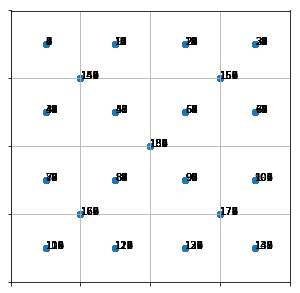

In [10]:
show_anchors(anchors,(4,4))

In [12]:
learn = Learner(data,SSD_multi_Model(),loss_func=SSD_loss)

In [13]:
learn.split(lambda m: (m.body[6],m.drop))
learn.freeze_to(-1)

In [14]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.63E-03
Min loss divided by 10: 7.59E-02


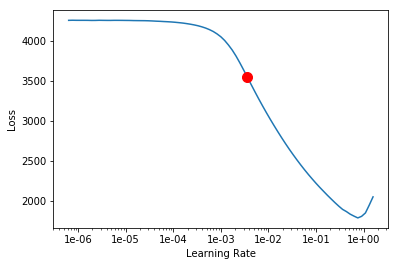

In [15]:
learn.recorder.plot(suggestion=True)

In [16]:
lr = 7e-2

In [17]:
learn.fit_one_cycle(6,slice(lr))

epoch,train_loss,valid_loss,time
0,222.644241,64.613556,01:03
1,84.839706,42.075928,01:04
2,58.849567,45.766747,01:05
3,49.402805,38.765572,01:05
4,42.695400,36.299816,01:04
5,38.663433,34.549953,01:04


In [18]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 2.29E-07


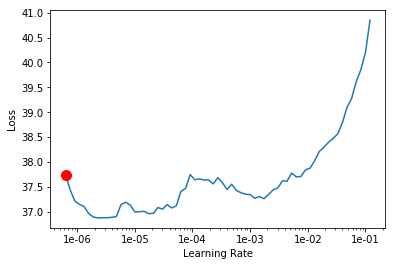

In [19]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [20]:
learn.fit_one_cycle(10,slice(1e-7,lr/5))

epoch,train_loss,valid_loss,time
0,36.379955,33.995495,01:10
1,35.414890,33.358971,01:10
2,34.777027,40.129044,01:10
3,34.205223,31.045540,01:10
4,32.707451,99181.734375,01:10
5,31.376633,29.444654,01:10
6,30.268894,27.587633,01:11
7,28.982456,26.823177,01:10
8,28.012230,35.838768,01:10
9,27.541615,26.370287,01:10


In [21]:
learn.model.eval()

SSD_multi_Model(
  (body): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [22]:
xb,yb = next(iter(learn.data.valid_dl))
xb.shape

torch.Size([64, 3, 224, 224])

In [23]:
preds = learn.model(xb)

In [134]:
idx = 21
t_bbox,t_clas = un_pad(yb[0][idx],yb[1][idx])
t_bbox,t_clas

(tensor([[-0.5916, -0.3400,  0.4054,  0.7720]], device='cuda:0'),
 tensor([1], device='cuda:0'))

In [135]:
p_cls_test = preds[1][idx][:,1:].max(dim=1)
p_cls_test

(tensor([-4.6288, -5.1598, -5.2401, -4.4391, -5.1504, -4.4752, -4.5616, -4.5538,
         -5.6500, -5.1777, -5.6883, -5.6344, -4.4412, -4.7677, -5.4493, -4.8157,
         -4.8751, -5.3502, -5.7263, -5.0934, -5.2142, -5.2307, -5.5370, -5.3242,
         -5.1360, -5.2629, -5.8853, -5.5145, -4.2069, -4.7842, -5.0281, -4.7476,
         -4.4682, -5.2471, -5.2156, -4.7791, -4.2383, -4.7580, -4.8935, -4.0958,
         -4.4658, -4.2830, -3.8563, -4.3088, -3.6416, -4.2251, -4.0376, -4.2999,
         -3.7643, -4.2220, -4.1711, -3.0475, -3.7997, -3.6182, -3.7122, -3.5787,
         -3.8693, -3.4927, -4.3731, -4.7154, -2.6736, -3.3640, -3.8652, -3.9771,
         -4.5910, -4.4881, -4.0889, -4.3433, -4.3378, -2.9258, -3.2338, -3.7047,
         -4.7530, -4.4166, -4.6435, -4.3757, -3.6741, -3.9308, -3.7935, -4.1450,
         -4.0842, -4.4587, -4.8138, -3.8727, -3.3544, -4.1663, -4.3561, -3.1567,
         -3.9467, -3.8915, -5.1039, -4.7123, -3.8204, -3.6399, -4.3035, -4.3434,
         -3.0928, -3.9028, -

In [136]:
idx_clas = p_cls_test[0].sigmoid() > 0.1
idx_clas

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1],
       device='cuda:0', dtype=torch.uint8)

In [137]:
p_f_clas = (p_cls_test[1] + 1) * (idx_clas).long()

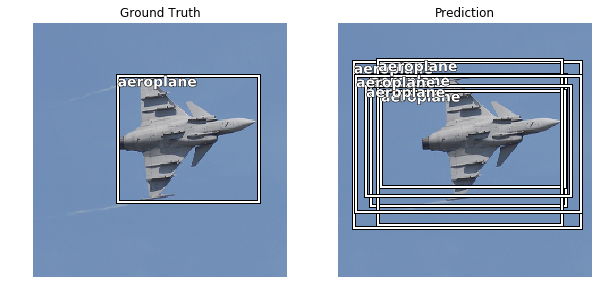

In [138]:
img = vision.Image(denormalize(xb[idx],*tensor(imagenet_stats)))
img_box = ImageBBox.create(224,224,yb[0][idx].cpu(),labels=yb[1][idx],classes=data.classes,scale=False)


p_final_bbox = act_to_bbox(preds[0][idx].cpu(),anchors)
t_bbox = p_final_bbox.cuda().index_select(dim=0,index=idx_clas.nonzero().squeeze())
test_clas = p_f_clas.index_select(dim=0,index=idx_clas.nonzero().squeeze())
p_img_box = ImageBBox.create(224,224,t_bbox.cpu(),test_clas,classes=data.classes,scale=False)

fig,axes = plt.subplots(1,2,figsize=(10,6))
img.show(ax=axes[0],y=img_box,title='Ground Truth')
img.show(ax=axes[1],y=p_img_box,title='Prediction')

In [141]:
def show_img(idx):
    t_bbox,t_clas = un_pad(yb[0][idx],yb[1][idx])
    p_cls_test = preds[1][idx][:,1:].max(dim=1)
    idx_clas = p_cls_test[0].sigmoid() > 0.1
    p_f_clas = (p_cls_test[1] + 1) * (idx_clas).long()
    img = vision.Image(denormalize(xb[idx],*tensor(imagenet_stats)))
    img_box = ImageBBox.create(224,224,yb[0][idx].cpu(),labels=yb[1][idx],classes=data.classes,scale=False)


    p_final_bbox = act_to_bbox(preds[0][idx].cpu(),anchors)
    t_bbox = p_final_bbox.cuda().index_select(dim=0,index=idx_clas.nonzero().squeeze())
    test_clas = p_f_clas.index_select(dim=0,index=idx_clas.nonzero().squeeze())
    p_img_box = ImageBBox.create(224,224,t_bbox.cpu(),test_clas,classes=data.classes,scale=False)

    fig,axes = plt.subplots(1,2,figsize=(10,6))
    img.show(ax=axes[0],y=img_box,title='Ground Truth')
    img.show(ax=axes[1],y=p_img_box,title='Prediction')

# Results

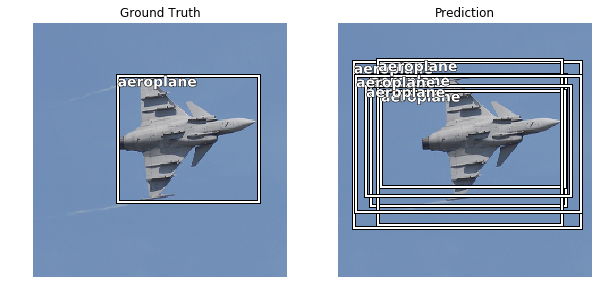

In [142]:
show_img(21)

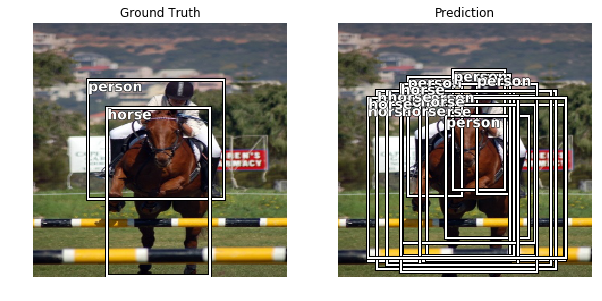

In [147]:
show_img(26)

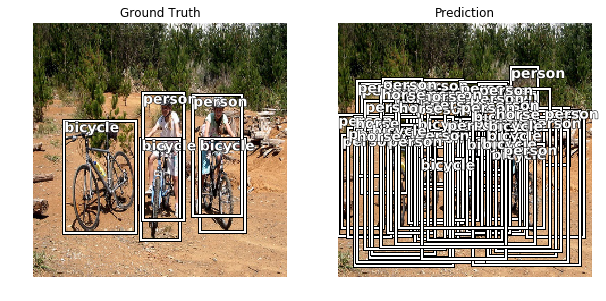

In [150]:
show_img(2)

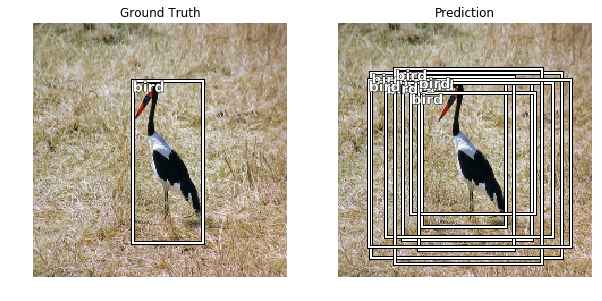

In [155]:
show_img(7)

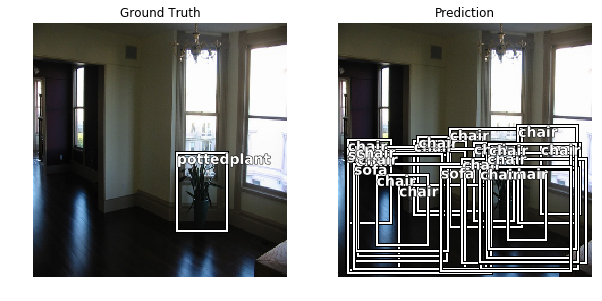

In [156]:
show_img(30)

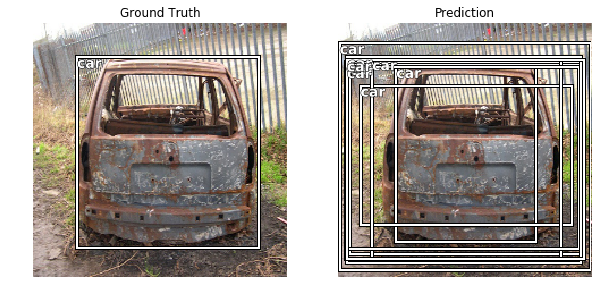

In [158]:
show_img(32)

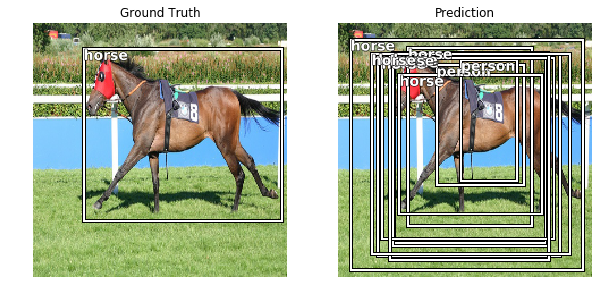

In [161]:
show_img(35)

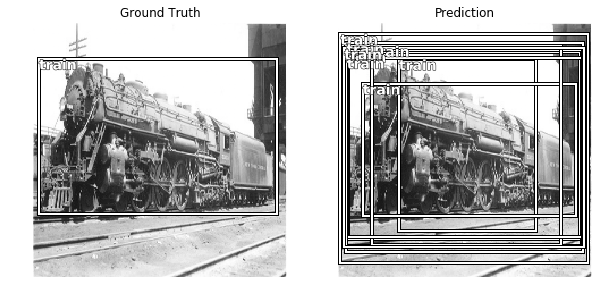

In [163]:
show_img(37)

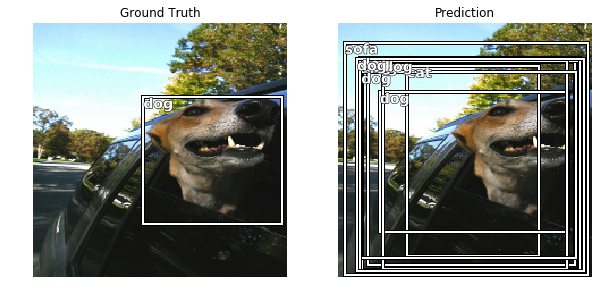

In [167]:
show_img(45)

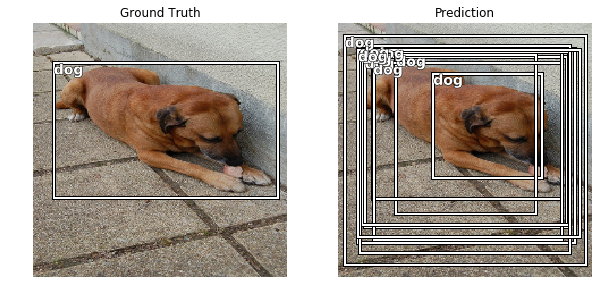

In [168]:
show_img(48)

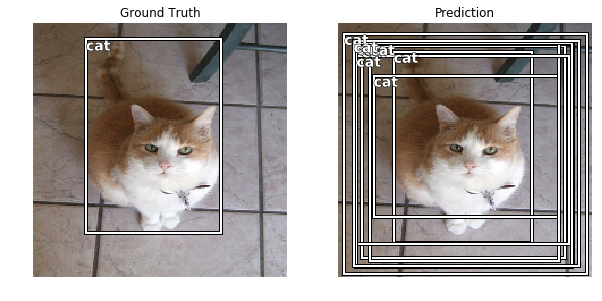

In [171]:
show_img(54)

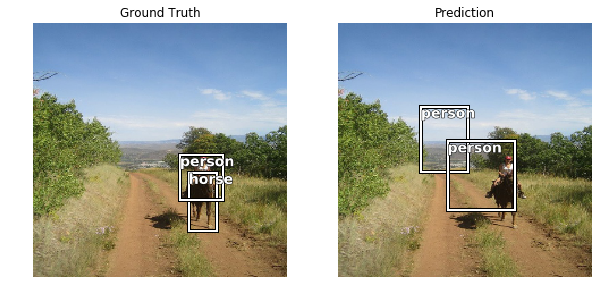

In [172]:
show_img(55)

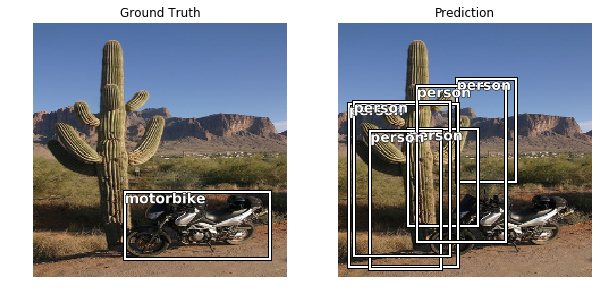

In [174]:
show_img(60)

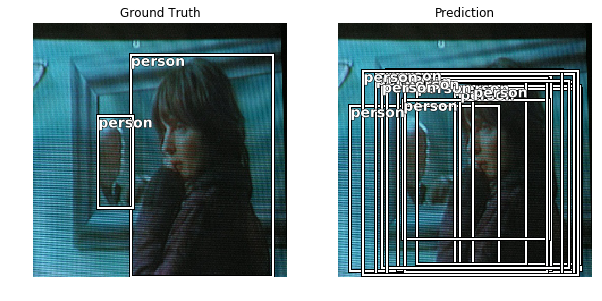

In [182]:
show_img(14)

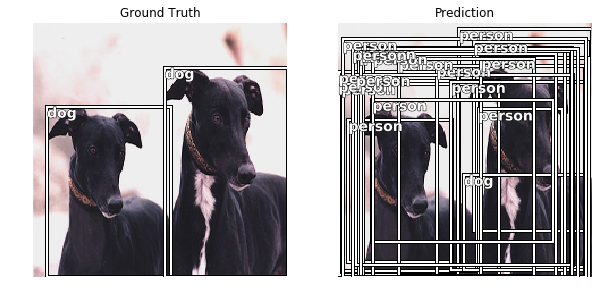

In [183]:
show_img(18)

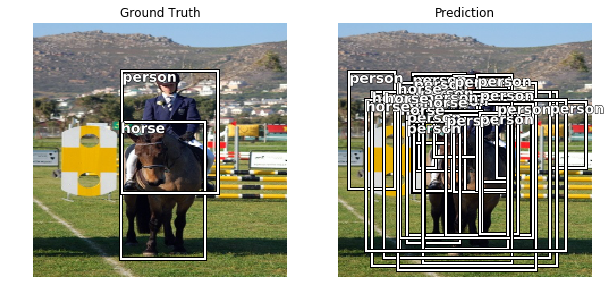

In [191]:
show_img(17)